# Visualizing spatial data in Python
We have a number of options for displaying spatial data using Python. Previously, we've explored how the ArcGIS API for Python can make some quick and nice looking maps. However, these maps are quite difficult to modify in terms of customizing how points and polygons are rendered. (I'm hopeful ESRI will make this easier, but right now the technology still seems a bit young...)

Here we explore a few alternatives Python packages that allow us to create static and interactive maps. These include:
* [`contextily`](https://contextily.readthedocs.io/en/latest/intro_guide.html) allows us to plop a nice basemap behind our geographic plots
* `mplleaflet` allows us to add *interactive* basemaps to our plots
* `folium` another means for allowing for interactive maps

A bit later on, we'll examine how these actually work - a nice transition to a discussion on web services. For now, however, a good start is to get a feel for how maps are included in the plots we create.

### Import the packages we'll be using. 

In [1]:
#Import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt # static maps and plots
import contextily as cx # static maps and basemaps
import mplleaflet # interactive maps - web service - can share html (requires geographic projection)
import folium # interactive maps

## Getting data
First we'll fetch some NWIS gage location data to plot. Below is a call to the National Water Inventory System (NWIS) web server to fetch a list of water gage locations for North Carolina.

In [2]:
#Get the list of site names for NC using the NWIS API
theURL = ('https://waterdata.usgs.gov/nwis/inventory?' + \
          'state_cd=nc&' + \
          'group_key=NONE&' + \
          'format=sitefile_output&' + \
          'sitefile_output_format=rdb&' + \
          'column_name=site_no&' + \
          'column_name=huc_cd&' + \
          'column_name=station_nm&' + \
          'column_name=site_tp_cd&' + \
          'column_name=dec_lat_va&' + \
          'column_name=dec_long_va&' + \
          'column_name=drain_area_va&' + \
          'column_name=rt_bol&' + \
          'column_name=alt_va&' + \
          'list_of_search_criteria=state_cd')
colnames=['site_no','huc_code','station_nm','site_tp_cd','lat','lng','agent','datum',
          'd_area','real_time','alt','alt_a','alt_datum']

#Pull the data from the URL
dfNWIS = pd.read_csv(theURL,
                     skiprows=34,
                     sep='\t',
                     names=colnames,
                     index_col='site_no',
                     dtype={'huc_code':'str','real_time':'boolean'}).drop(['alt_a'],axis=1)

#Drop rows with null values
dfNWIS.dropna(inplace=True)

#Display
dfNWIS.head()

,huc_code,station_nm,site_tp_cd,lat,lng,agent,datum,d_area,real_time,alt,alt_datum
site_no,,,,,,,,,,,
2043410,03010205,"NORTHWEST RIVER ABOVE MOUTH NEAR MOYOCK, NC",ST,36.512222,-76.086667,S,NAD83,196.0,True,10.00,NGVD29
2043415,03010205,"TULL CREEK AT SR 1222 NEAR CURRITUCK, NC",ST,36.496389,-76.084167,S,NAD83,52.0,True,10.00,NGVD29
2043750,03010205,"CROSS CANAL DITCH NR HOLLY GROVE, NC",ST-CA,36.509875,-76.552450,S,NAD83,24.0,False,15.00,NGVD29
204382800,03010205,"PASQUOTANK RIVER NEAR SOUTH MILLS, NC",ST,36.421389,-76.342500,S,NAD83,64.0,True,-5.50,NAVD88
2053200,03010204,"POTECASI CREEK NEAR UNION, NC",ST,36.370833,-77.025556,S,NAD83,225.0,True,3.53,NGVD29


In [3]:
#Create a geodataframe from our data
geom = [Point(xyz) for xyz in zip(dfNWIS['lng'],dfNWIS['lat'],dfNWIS['alt'])]
gdfNWIS = gpd.GeoDataFrame(dfNWIS,geometry=geom,crs=4269)

In [4]:
#Create another geodataframe from the NC HUC 8 data
gdfHUC12 = gpd.read_file('./data/12Digit_HUC_Subwatersheds.shp')

In [5]:
#Create a map of just NC boundary by dissolving the HUCs
gdf_NC = gdfHUC12.dissolve(gdfHUC12['ACRES']/gdfHUC12['ACRES'])

## Static plots
### Geopandas
First a review of plotting geopandas dataframes. Full documentation is here:  
* Documentation: https://geopandas.org/mapping.html
* Reference: https://geopandas.org/reference.html#geopandas.GeoDataFrame.plot

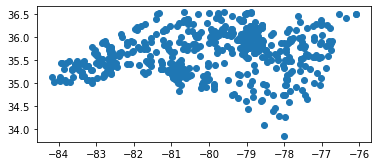

In [6]:
#Plot point objects
gdfNWIS.plot();

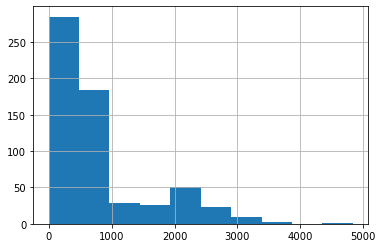

In [7]:
#Quick look at distribution of the alt values
gdfNWIS['alt'].hist();

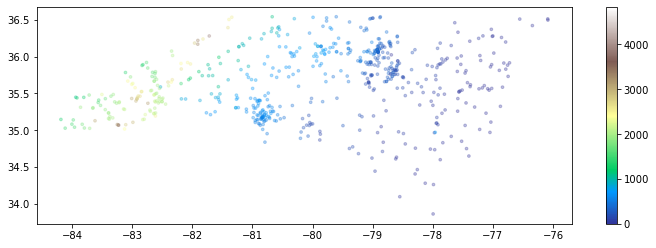

In [8]:
#Plot a field, setting aesthetics
gdfNWIS.plot(
    column='alt', # which col of data t oplot
    cmap='terrain', # color map
    legend=True, 
    marker='.',
    markersize=30,
    alpha=0.3,
    figsize=(12,4),
);

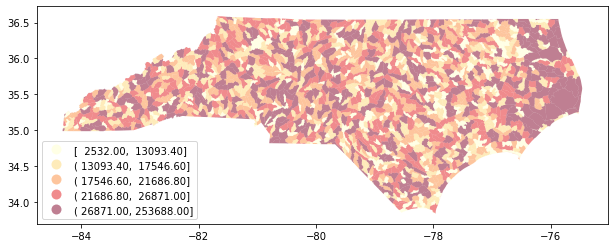

In [9]:
#Another example: HUCs
gdfHUC12.plot(
    column="ACRES",
    scheme="quantiles",
    k=5,
    legend=True,
    legend_kwds={'loc': 'lower left'},
    cmap='YlOrRd',
    alpha=0.5,
    figsize=(19,4)
);

► Multi layer plot

In [ ]:
#Start by saving the first plot to a variable (often "ax")
ax = gdfHUC12.plot(
    column='HUC_8',
    cmap='tab20',
    edgecolor='darkgrey',
    linewidth=0.3,
    alpha=0.3,
    figsize=(16,8)
)

#Then add the other layers, assiging the property ax to the variable above
gdfNWIS.plot(
    ax=ax,
    column='alt',
    cmap='terrain',
    marker='.',
    markersize=30,
    alpha=0.9
);

#Then add the boundary
gdf_NC.boundary.plot(ax=ax,color='black');

### Adding a basemap with Contextily
Docs: https://contextily.readthedocs.io/en/latest/intro_guide.html
Contextily enables us to add basemaps to our plots.

In [ ]:
#As above...
ax = gdfNWIS.plot(
    column='alt',
    cmap='terrain',
    alpha=1,
    figsize=(16,9)
)

#Add the state line
gdf_NC.boundary.plot(ax=ax)

#Now add a basemap; note we have to supply the crs
theCRS = gdfNWIS.crs
cx.add_basemap(ax,crs=theCRS)

→ Same plot as above, but we transform our data to match contextily's (EPSG 3857 - Web Mercator), and it plots faster!

In [ ]:
#As above, but transform our data to epsg 3857
ax = gdfNWIS.to_crs(3857).plot(
    column='alt',
    cmap='terrain',
    alpha=1,
    figsize=(16,9)
)

#Add the state line
gdf_NC.boundary.to_crs(3857).plot(ax=ax)

#Now add a basemap; note we have to supply the crs
cx.add_basemap(ax)

We can change the basemap used by selecting the basemap provider and then seeing what basemaps each provides:

In [ ]:
#View the providers
cx.providers.keys()

In [ ]:
#View the basemaps provided by Stamen
cx.providers.Stamen.keys()

In [ ]:
#As above, but transform our data to epsg 3857
ax = gdfNWIS.to_crs(3857).plot(
    column='alt',
    cmap='terrain',
    alpha=1,
    figsize=(16,9)
)

#Add the state line
gdf_NC.boundary.to_crs(3857).plot(ax=ax)

#Now add a basemap; note we have to supply the crs
cx.add_basemap(ax,source=cx.providers.Stamen.Watercolor)

## Interactive Maps

### Easy maps with `mplleaflet`
Docs: https://github.com/jwass/mplleaflet

In [ ]:
#As above, but transform our data to epsg 3857
ax = gdfHUC12.plot(
    column='HUC_8',
    cmap='tab20',
    edgecolor='darkgrey',
    linewidth=0.3,
    alpha=0.3,
    figsize=(16,8)
)

#Then add the other layers, assiging the property ax to the variable above
gdfNWIS.plot(
    ax=ax,
    column='alt',
    cmap='terrain',
    marker='.',
    markersize=30,
    alpha=0.9
);

#Then add the boundary
gdf_NC.boundary.plot(ax=ax,color='black');

#Now, the magic! uncomment and run again
mplleaflet.show()

## Visualizing with the `folium` package
https://python-visualization.github.io/folium/

Folium is a Python wrapper for the JavaScript "Leaflet" Package...

In [ ]:
import folium
folium.__version__

### Setting up to visualize our data
We are going to construct a map, and when we do, we'll have to specify where our map should be centered and how far zoomed it should be. To compute the center, we can easily compute the median Lat and Long values from our data...

In [ ]:
#Determine the median lat/lng
medianLat = dfNWIS['lat'].median()
medianLng = dfNWIS['lng'].median()
print (medianLat,medianLng)

In [ ]:
#Construct the map
m = folium.Map(location=[medianLat,medianLng],
               zoom_start = 7,
               tiles='OpenStreetMap'              
             )
#Display the map
m

Try:
* Change the zoom value: does higher or lower values zoom in to a smaller area?
* Change the tiles to `Stamen Terrain`,`Stamen Watercolor`, `Stamen Toner`. [more](https://python-visualization.github.io/folium/quickstart.html#Getting-Started).

In [ ]:
#Create the marker, we'll use a circle Marker
myMarker = folium.CircleMarker(location=[medianLat,medianLng],
                               color='red',
                               fill=True,
                               fill_opacity=0.5,
                               radius=30,
                               tooltip='Map Center'
                              )
myMarker.add_to(m)
m

In [ ]:
#Recreate the map object to clear markers
m = folium.Map(location=[medianLat,medianLng],
               zoom_start = 7,
               tiles='OpenStreetMap'              
             )

#Loop through all features and add them to the map as markers
for row in dfNWIS.itertuples():
    #Get info for the record
    lat = row.lat
    lng = row.lng
    site_no = row.station_nm
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        color='blue',
                        fill=True,
                        fill_opacity=0.6,
                        radius=3,
                        tooltip=site_no
                       ).add_to(m)
#Show the map
m

In [ ]:
#Import the folium MarkerCluster object class
from folium.plugins import MarkerCluster

#Recreate the map object to clear markers
m = folium.Map(location=[medianLat,medianLng],
               zoom_start = 7,
               tiles='cartodbpositron'              
             )

#Create a marker cluster object
mc = MarkerCluster()

#Loop through all features and add them to the map as markers
for row in dfNWIS.itertuples():
    #Get info for the record
    lat = row.lat
    lng = row.lng
    site_no = row.station_nm
    #Create the marker object, adding them to the map object
    marker = folium.CircleMarker(location=[lat,lng],
                                 color='blue',
                                 fill=True,
                                 fill_opacity=0.6,
                                 radius=3,
                                 tooltip=site_no)
    #Add the marker to the markerCluster
    mc.add_child(marker)
    
#Add marker clusters to the map
m.add_child(mc)

#Show the map
m

---
## GeoPandas → MatPlotLib
GeoPandas has some plotting capabilities to visualize geodataframes. We can also plot geodataframes on a leaflet map by converting the dataframe to GeoJSON object. 

Resource: http://geopandas.org/mapping.html#

By importing Matplotlib's pyplot interface, we can add more mapping functionality. Specifically, once we create a figure, we can access it as the pyploy or "`plt`" object, and then we can apply aesthetics to this object.

In [ ]:
#Plot the data, this time coloring features by it's longitude value
gdfNWIS.plot('lng',          #The column with values to color 
             cmap='Reds',    #The colormap to use for the colors
             figsize=(12,8)) #The size of the map

#Add aesthetics via the matplotlib pyplt interface
plt.title("Map") #Add a title to the figure
plt.grid()       #Add gridlines
plt.plot();      #Display the plots

#### Polygon data

In [ ]:
#Plot, colored by a discrete attribute
gdfHUC12.plot('HUC_8',cmap='tab20');

In [ ]:
#Dissolve on HUC_8
gdfHUC8 = gdfHUC12.dissolve(by='HUC_8')

In [ ]:
#Project and compute areas
gdfHUC8_utm = gdfHUC8.to_crs(26917)
gdfHUC8_utm['area_m2'] = gdfHUC8_utm['geometry'].area

In [ ]:
#Plot, colored by a contiuous attribute
gdfHUC8_utm.plot('area_m2',
                 cmap='coolwarm',
                 legend=True,
                 edgecolor='black',
                 figsize=(15,5))
plt.grid(True)
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing');

In [ ]:
#Subset HUC 8 = 03020201 (Upper Neuse)
gdfNeuse = gdfHUC12.query('HUC_8 == "03020201"')
gdfNeuse.plot('ACRES',cmap='Blues',edgecolor='grey');

#### Plotting multiple layers
By assigning the first plot to a variable name (here `theMap`), we can add more layers by specifying which axis to plot the layer on top of.  

In [ ]:
#Plot the HUC8s, assigning the plot to the variable "theMap"
theMap = gdfHUC8_utm.plot('area_m2',cmap='twilight',legend=True,figsize=(15,5))
plt.grid(True)
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')

#Plot the Neuse (projected to UTM) on top by specifing that it use the same axes
gdfNeuse.to_crs(26917).plot(ax=theMap,color='green');

#### Displaying a geopandas dataframe in a folium map

In [ ]:
#Create a folium map
m = folium.Map(location=[medianLat,medianLng],
               zoom_start = 8,
               tiles='OpenStreetMap'              
             )
#Convert the geopandas dataframe to a GeoJSON object
gdfNeuse_json = gdfNeuse.to_json()
#Convert the GeoJSon object to a folium layer
gdfNeuse_layer = folium.GeoJson(gdfNeuse_json)
#Add the layer to the map
gdfNeuse_layer.add_to(m)
#Show the map
m